# 데이터 불러오기 및 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, roc_auc_score, recall_score, classification_report, silhouette_score, precision_score, accuracy_score
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

In [ ]:
# import matplotlib
# from matplotlib import font_manager

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv

# fontpaths = ["/usr/share/fonts/truetype/nanum/"]
# font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

# for ff in font_files:
#     font_manager.fontManager.addfont(ff)

# matplotlib.rc('font', family="NanumGothic")
# matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
DATA_PATH = "/content/drive/MyDrive/멋쟁이사자처럼/DataThon/dataset/Moulding/"
SEED = 42

In [ ]:
train = pd.read_csv(f"{DATA_PATH}train_cn7.csv")    # cn7 / rg3
test = pd.read_csv(f"{DATA_PATH}test_cn7.csv")  # cn7 / rg3
unlab = pd.read_csv(f"{DATA_PATH}unlab_cn7.csv")    # cn7 / rg3

unlab.drop(columns=["Unnamed: 0"], inplace=True)

train['PART_FACT_SERIAL'] = train['PART_FACT_SERIAL'].astype(object)
test['PART_FACT_SERIAL'] = test['PART_FACT_SERIAL'].astype(object)
unlab['PART_FACT_SERIAL'] = unlab['PART_FACT_SERIAL'].astype(object)

labeled = pd.concat([train, test], axis=0)
serial = labeled["PART_FACT_SERIAL"].unique().tolist()

unlab = unlab[unlab["EQUIP_NAME"] == "650톤-우진2호기"]
unlab = unlab[unlab["PART_FACT_SERIAL"].isin(serial)]
unlab = unlab[unlab["Switch_Over_Position"] == 0]

train_ft = train.copy()
test_ft = test.copy()
unlab_ft = unlab.copy()

train_ft = labeled[:train_ft.shape[0]].copy()
test_ft = labeled[train_ft.shape[0]:].copy()

label_drop_cols = ["_id", "TimeStamp", "PART_FACT_PLAN_DATE", "EQUIP_CD", "EQUIP_NAME", "PassOrFail", "Reason", 'Barrel_Temperature_7',
             'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_5', 'Mold_Temperature_6', 'Mold_Temperature_7',
             'Mold_Temperature_8', 'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11', 'Mold_Temperature_12']
unlab_drop_cols = [col for col in unlab_ft.columns if col not in train_ft.columns] + [col for col in label_drop_cols if col in unlab_ft.columns]

train_ft = train_ft.drop(label_drop_cols, axis=1).copy()
test_ft = test_ft.drop(label_drop_cols, axis=1).copy()
unlab_ft = unlab_ft.drop(unlab_drop_cols, axis=1).copy()

# 학습용 정답데이터 => 제품마다 코드 수정 필요
y_train = (train['PassOrFail'] == 'N').astype(int)

# 테스트용 정답데이터 => 제품마다 코드 수정 필요
target = (test['PassOrFail'] == 'N').astype(int)

def preprocess(df, test=False, enc=None, scaler=None):
    obj_col = df.select_dtypes('object').columns

    if not(test):
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(df[obj_col])
    df[enc.get_feature_names_out()] = enc.transform(df[obj_col]).toarray()
    df.drop(obj_col, axis=1, inplace=True)

    if not(test):
        scaler = RobustScaler()
        scaler.fit(df)
    df = scaler.transform(df)

    return df, enc, scaler

train_ft, enc, scaler = preprocess(train_ft)
test_ft, _, _ = preprocess(test_ft, test=True, enc=enc, scaler=scaler)
unlab_ft, _, _ = preprocess(unlab_ft, test=True, enc=enc, scaler=scaler)

train_ft.shape, test_ft.shape, unlab_ft.shape, y_train.shape, target.shape

((2400, 35), (1574, 35), (10048, 35), (2400,), (1574,))

# DBSCAN 하이퍼파라미터

- DBSCAN
```yaml
eps:
    value: 12.58119167847988
min_samples:
    value: 26
```

# Pseudo Labeling

## 1차 비지도 학습 및 pseudo labeling

In [ ]:
model = DBSCAN(eps=12.58119167847988,
               min_samples=26)

model.fit(train_ft)

DBSCAN(eps=12.58119167847988, min_samples=26)

In [ ]:
pred = model.fit_predict(test_ft)

normal = test_ft[pred != -1]
anomalies = test_ft[pred == -1]
ratio = len(anomalies) / len(test_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

정상 : 1541, 이상치 : 33, 이상치 비율 : 0.0210


In [ ]:
pred = np.where(pred == -1, 1, 0)
print(f"f1_score : {f1_score(target, pred):.4f}")
print(classification_report(target, pred))

f1_score : 0.8852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1546
           1       0.82      0.96      0.89        28

    accuracy                           1.00      1574
   macro avg       0.91      0.98      0.94      1574
weighted avg       1.00      1.00      1.00      1574



----

In [ ]:
clustered_labels = model.fit_predict(unlab_ft)
np.unique(clustered_labels) # -1은 이상치로 분류된

array([-1,  0,  1,  2,  3,  4,  5])

In [ ]:
core_sample_idx = model.core_sample_indices_  # core sample index
core_samples = model.components_  # core sample data

# 각 데이터가 가장 가까운 코어 샘플과의 거리
core_distances = np.min(pairwise_distances(unlab_ft, core_samples), axis=1)

outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)
normal_idx = np.where(clustered_labels != -1)[0]    # 정상

# 이상치 군집에서의 상위 10%
n_outliers_top = max(1, int(len(outliers_idx) * 0.1))  # 상위 10%, 최소 1개
outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

# 이상치를 제외한 군집에서의 상위 10% (정상으로 간주된)
normal_top_idx = []
unique_clusters = np.unique(clustered_labels[normal_idx])
for cluster_id in unique_clusters:
    cluster_points = np.where(clustered_labels == cluster_id)[0]  # 해당 군집의 인덱스
    n_normal_top = max(1, int(len(cluster_points) * 0.1))  # 상위 10%, 최소 1개
    top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
    normal_top_idx.extend(top_idx)

pseudo_labeled_outliers = unlab_ft[outliers_top_idx]  # 이상치 상위 10%
pseudo_labeled_normal = unlab_ft[normal_top_idx]  # 군집별 상위 10%

# 결과 출력
print("Pseudo-labeled Outliers Shape:", pseudo_labeled_outliers.shape)
print("Pseudo-labeled normal Shape:", pseudo_labeled_normal.shape)

Pseudo-labeled Outliers Shape: (6, 34)
Pseudo-labeled normal Shape: (996, 34)


In [ ]:
# 기존 학습 데이터에 상위 10% 정상 데이터 추가
added_ft = np.vstack([train_ft, pseudo_labeled_normal])  # 정상 데이터 추가

# 상위 10% 이상치 데이터를 따로 저장
outliers_data = pseudo_labeled_outliers  # 이상치 데이터 저장

# 예측된 레이블이 없는 데이터에서 상위 10% 정상 및 이상치 데이터를 제외
remained_unlab_ft = np.delete(unlab_ft, np.concatenate([outliers_top_idx, normal_top_idx]), axis=0)

# 결과 출력
print(f"Updated Normal Data Shape: {added_ft.shape}")
print(f"Outliers Data Shape: {outliers_data.shape}")
print(f"Remaining Unlabeled Data Shape: {remained_unlab_ft.shape}")

Updated Normal Data Shape: (3396, 34)
Outliers Data Shape: (6, 34)
Remaining Unlabeled Data Shape: (9046, 34)


----

## 1차 pseudo labeling 후 다시 학습 및 예측

In [ ]:
model = DBSCAN(
    eps=12.58119167847988,
    min_samples=26)

model.fit(added_ft)

DBSCAN(eps=12.58119167847988, min_samples=26)

In [ ]:
pred = model.fit_predict(test_ft)

normal = test_ft[pred != -1]
anomalies = test_ft[pred == -1]
ratio = len(anomalies) / len(test_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

정상 : 1541, 이상치 : 33, 이상치 비율 : 0.0210


In [ ]:
pred = np.where(pred == -1, 1, 0)
print(f"f1_score : {f1_score(target, pred):.4f}")
print(classification_report(target, pred))

f1_score : 0.8852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1546
           1       0.82      0.96      0.89        28

    accuracy                           1.00      1574
   macro avg       0.91      0.98      0.94      1574
weighted avg       1.00      1.00      1.00      1574



----

In [ ]:
clustered_labels = model.fit_predict(remained_unlab_ft)
np.unique(clustered_labels) # -1은 이상치로 분류된

array([-1,  0,  1,  2,  3,  4,  5])

In [ ]:
core_sample_idx = model.core_sample_indices_  # core sample index
core_samples = model.components_  # core sample data

# 각 데이터가 가장 가까운 코어 샘플과의 거리
core_distances = np.min(pairwise_distances(unlab_ft, core_samples), axis=1)

outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)
normal_idx = np.where(clustered_labels != -1)[0]    # 정상

# 이상치 군집에서의 상위 10%
n_outliers_top = max(1, int(len(outliers_idx) * 0.1))  # 상위 10%, 최소 1개
outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

# 이상치를 제외한 군집에서의 상위 10% (정상으로 간주된)
normal_top_idx = []
unique_clusters = np.unique(clustered_labels[normal_idx])
for cluster_id in unique_clusters:
    cluster_points = np.where(clustered_labels == cluster_id)[0]  # 해당 군집의 인덱스
    n_normal_top = max(1, int(len(cluster_points) * 0.1))  # 상위 10%, 최소 1개
    top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
    normal_top_idx.extend(top_idx)

pseudo_labeled_outliers = remained_unlab_ft[outliers_top_idx]  # 이상치 상위 10%
pseudo_labeled_normal = remained_unlab_ft[normal_top_idx]  # 군집별 상위 10%

# 결과 출력
print("Pseudo-labeled Outliers Shape:", pseudo_labeled_outliers.shape)
print("Pseudo-labeled normal Shape:", pseudo_labeled_normal.shape)

Pseudo-labeled Outliers Shape: (5, 34)
Pseudo-labeled normal Shape: (896, 34)


In [ ]:
# 기존 학습 데이터에 상위 10% 정상 데이터 추가
added_ft = np.vstack([added_ft, pseudo_labeled_normal])  # 정상 데이터 추가

# 상위 10% 이상치 데이터를 따로 저장
outliers_data = np.vstack([outliers_data, pseudo_labeled_outliers]) if len(outliers_data) > 0 else pseudo_labeled_outliers  # 이상치 데이터 추가

# 예측된 레이블이 없는 데이터에서 상위 10% 정상 및 이상치 데이터를 제외
remained_unlab_ft = np.delete(remained_unlab_ft, np.concatenate([outliers_top_idx, normal_top_idx]), axis=0)

# 결과 출력
print(f"Updated Normal Data Shape: {added_ft.shape}")
print(f"Outliers Data Shape: {outliers_data.shape}")
print(f"Remaining Unlabeled Data Shape: {remained_unlab_ft.shape}")

Updated Normal Data Shape: (4292, 34)
Outliers Data Shape: (11, 34)
Remaining Unlabeled Data Shape: (8145, 34)


----

## 2차 pseudo labeling 후 다시 학습 및 예측

In [ ]:
model = DBSCAN(
    eps=12.58119167847988,
    min_samples=26)

model.fit(added_ft)

DBSCAN(eps=12.58119167847988, min_samples=26)

In [ ]:
pred = model.fit_predict(test_ft)

normal = test_ft[pred != -1]
anomalies = test_ft[pred == -1]
ratio = len(anomalies) / len(test_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

정상 : 1541, 이상치 : 33, 이상치 비율 : 0.0210


In [ ]:
pred = np.where(pred == -1, 1, 0)
print(f"f1_score : {f1_score(target, pred):.4f}")
print(classification_report(target, pred))

f1_score : 0.8852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1546
           1       0.82      0.96      0.89        28

    accuracy                           1.00      1574
   macro avg       0.91      0.98      0.94      1574
weighted avg       1.00      1.00      1.00      1574



----

In [ ]:
clustered_labels = model.fit_predict(remained_unlab_ft)
np.unique(clustered_labels) # -1은 이상치로 분류된

array([-1,  0,  1,  2,  3,  4,  5])

In [ ]:
core_sample_idx = model.core_sample_indices_  # core sample index
core_samples = model.components_  # core sample data

# 각 데이터가 가장 가까운 코어 샘플과의 거리
core_distances = np.min(pairwise_distances(unlab_ft, core_samples), axis=1)

outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)
normal_idx = np.where(clustered_labels != -1)[0]    # 정상

# 이상치 군집에서의 상위 10%
n_outliers_top = max(1, int(len(outliers_idx) * 0.1))  # 상위 10%, 최소 1개
outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

# 이상치를 제외한 군집에서의 상위 10% (정상으로 간주된)
normal_top_idx = []
unique_clusters = np.unique(clustered_labels[normal_idx])
for cluster_id in unique_clusters:
    cluster_points = np.where(clustered_labels == cluster_id)[0]  # 해당 군집의 인덱스
    n_normal_top = max(1, int(len(cluster_points) * 0.1))  # 상위 10%, 최소 1개
    top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
    normal_top_idx.extend(top_idx)

pseudo_labeled_outliers = remained_unlab_ft[outliers_top_idx]  # 이상치 상위 10%
pseudo_labeled_normal = remained_unlab_ft[normal_top_idx]  # 군집별 상위 10%

# 결과 출력
print("Pseudo-labeled Outliers Shape:", pseudo_labeled_outliers.shape)
print("Pseudo-labeled normal Shape:", pseudo_labeled_normal.shape)

Pseudo-labeled Outliers Shape: (5, 34)
Pseudo-labeled normal Shape: (806, 34)


In [ ]:
# 기존 학습 데이터에 상위 10% 정상 데이터 추가
added_ft = np.vstack([added_ft, pseudo_labeled_normal])  # 정상 데이터 추가

# 상위 10% 이상치 데이터를 따로 저장
outliers_data = np.vstack([outliers_data, pseudo_labeled_outliers]) if len(outliers_data) > 0 else pseudo_labeled_outliers  # 이상치 데이터 추가

# 예측된 레이블이 없는 데이터에서 상위 10% 정상 및 이상치 데이터를 제외
remained_unlab_ft = np.delete(remained_unlab_ft, np.concatenate([outliers_top_idx, normal_top_idx]), axis=0)

# 결과 출력
print(f"Updated Normal Data Shape: {added_ft.shape}")
print(f"Outliers Data Shape: {outliers_data.shape}")
print(f"Remaining Unlabeled Data Shape: {remained_unlab_ft.shape}")

Updated Normal Data Shape: (5098, 34)
Outliers Data Shape: (16, 34)
Remaining Unlabeled Data Shape: (7334, 34)


# DBSCAN - Pseudo Labeling 자동화 (수정)

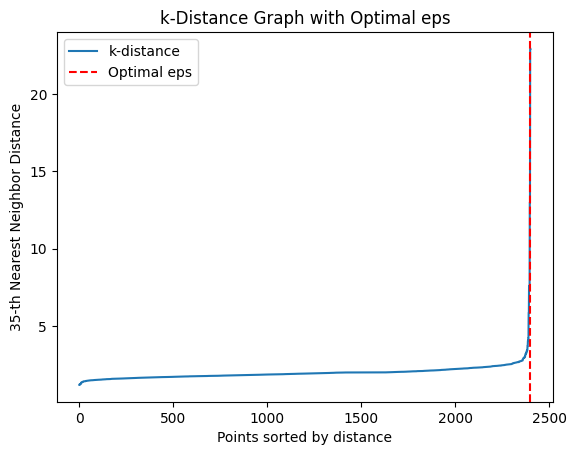

Optimal eps: 12.9912


In [ ]:
# k = min_samples - 1
min_samples = 36
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(train_ft)
distances, indices = neighbors_fit.kneighbors(train_ft)

# 거리 정렬
distances = np.sort(distances[:, -1])  # k번째 이웃 거리

# 1차 차분(기울기)
diff = np.diff(distances)

# 2차 차분(기울기 변화)
diff2 = np.diff(diff)

# 최대 기울기 변화 지점 찾기
elbow_index = np.argmax(diff2) + 1  # +1은 diff 차원 감소 보정

# 시각화
plt.plot(distances, label="k-distance")
plt.axvline(x=elbow_index, color="r", linestyle="--", label="Optimal eps")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples - 1}-th Nearest Neighbor Distance")
plt.legend()
plt.title("k-Distance Graph with Optimal eps")
plt.show()

print(f"Optimal eps: {distances[elbow_index]:.4f}")

```python
    "concat_size": 0.02, # 한번에 얼마나 레이블링 할지
    "abnormal_rate": 0.01, # 이상치를 얼마나 추출할지
    "usage_size":0.5, # unlab_ft에서 사용할 비율
```

In [ ]:
threshold = 0.05
remaining_ratio = 1.0

def pseudo_labeling(train_ft, unlab_ft, usage_size, eps=12.9912, min_samples=36, threshold=threshold, remaining_ratio=remaining_ratio):
    x = train_ft.copy()
    y = unlab_ft.copy()
    outliers_data = np.empty((0, y.shape[1]))
    iter = 1

    while remained_ratio >= (1 - usage_size):
        print("\n")
        print(f"--- {iter}차 Pseudo Labeling ---")

        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(x)

        clustered_labels = model.fit_predict(y)
        core_sample_idx = model.core_sample_indices_  # core sample index
        core_samples = model.components_  # core sample data

        # 각 데이터가 가장 가까운 코어 샘플과의 거리
        core_distances = np.min(pairwise_distances(y, core_samples), axis=1)

        outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)
        normal_idx = np.where(clustered_labels != -1)[0]    # 정상

        n_outliers_top = max(1, int(len(outliers_idx) * threshold))  # 상위 5%, 최소 1개
        outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

        # 이상치를 제외한 군집에서의 상위 10% (정상으로 간주된)
        normal_top_idx = []
        unique_clusters = np.unique(clustered_labels[normal_idx])
        for cluster_id in unique_clusters:
            cluster_points = np.where(clustered_labels == cluster_id)[0]  # 정상 군집의 인덱스
            n_normal_top = max(1, int(len(cluster_points) * threshold))  # 상위 5%, 최소 1개
            top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
            normal_top_idx.extend(top_idx)

        # 정상, 이상치 데이터 추출
        pseudo_labeled_outliers = y[outliers_top_idx]  # 이상치 군집 상위 5%
        pseudo_labeled_normal = y[normal_top_idx]  # 정상 군집별 상위 5%

        # 학습 데이터 및 이상치 데이터 업데이트
        x = np.vstack([x, pseudo_labeled_normal])  # 학습 데이터에 pseudo-labeled 정상 데이터 추가
        y = np.delete(y, np.concatenate([outliers_top_idx, normal_top_idx]), axis=0)  # pseudo-labeled 데이터 제거
        outliers_data = np.vstack([outliers_data, pseudo_labeled_outliers]) if outliers_data.size > 0 else pseudo_labeled_outliers

        # 하이퍼파라미터 업데이트 - eps
        neighbors = NearestNeighbors(n_neighbors=min_samples)
        neighbors_fit = neighbors.fit(x)
        distances, indices = neighbors_fit.kneighbors(x)
        distances = np.sort(distances[:, -1])
        diff = np.diff(distances)
        diff2 = np.diff(diff)
        elbow_index = np.argmax(diff2) + 1
        eps = distances[elbow_index]  # 새로운 최적 eps

        remaining_ratio = len(y) / len(unlab_ft)

        # 진행상황 출력
        print("Pseudo-labeled normal Shape:", pseudo_labeled_normal.shape)
        print("Pseudo-labeled Outliers Shape:", pseudo_labeled_outliers.shape)
        print(f"Updated train_ft Shape: {x.shape}")
        print(f"Updated unlab_ft Shape: {y.shape}")
        print(f"Updated Outliers Shape: {outliers_data.shape}")
        print(f"Updated EPS : {eps}")
        print(f"Remaining Ratio: {remaining_ratio:.3f}")

        iter += 1

        if remaining_ratio <= (1 - usage_size):
            break

    print("\n")
    print(f"train_ft Shape: {x.shape}")
    print(f"unlab_ft Shape: {y.shape}")
    print(f"Outliers Shape: {outliers_data.shape}")

    return x, y, outliers_data

In [ ]:
x, y, outliers_data = pseudo_labeling(train_ft, unlab_ft, using_ratio=0.3)



--- 1차 Pseudo Labeling ---
Pseudo-labeled normal Shape: (497, 35)
Pseudo-labeled Outliers Shape: (3, 35)
Updated train_ft Shape: (2897, 35)
Updated unlab_ft Shape: (9548, 35)
Updated Outliers Shape: (3, 35)
Updated EPS : 101.73944266948058
Remaining Ratio: 0.950


--- 2차 Pseudo Labeling ---
Pseudo-labeled normal Shape: (474, 35)
Pseudo-labeled Outliers Shape: (2, 35)
Updated train_ft Shape: (3371, 35)
Updated unlab_ft Shape: (9072, 35)
Updated Outliers Shape: (5, 35)
Updated EPS : 101.73944266948058
Remaining Ratio: 0.903


--- 3차 Pseudo Labeling ---
Pseudo-labeled normal Shape: (451, 35)
Pseudo-labeled Outliers Shape: (2, 35)
Updated train_ft Shape: (3822, 35)
Updated unlab_ft Shape: (8619, 35)
Updated Outliers Shape: (7, 35)
Updated EPS : 101.73944266948058
Remaining Ratio: 0.858


--- 4차 Pseudo Labeling ---
Pseudo-labeled normal Shape: (428, 35)
Pseudo-labeled Outliers Shape: (2, 35)
Updated train_ft Shape: (4250, 35)
Updated unlab_ft Shape: (8189, 35)
Updated Outliers Shape: (9, 

In [ ]:
def superviesed_modeling(train_ft, y_train, test_ft, target, seed=SEED):
    lr = LogisticRegression(random_state=seed)
    lr.fit(train_ft, y_train)
    lr_pred = lr.predict(test_ft)

    xgb = XGBClassifier(random_state=seed)
    xgb.fit(train_ft, y_train)
    xgb_pred = xgb.predict(test_ft)

    rf = RandomForestClassifier(random_state=seed)
    rf.fit(train_ft, y_train)
    rf_pred = rf.predict(test_ft)

    lgbm = LGBMClassifier(random_state=seed)
    lgbm.fit(train_ft, y_train)
    lgbm_pred = lgbm.predict(test_ft)

    print("Logistic Regression")
    print(f"f1_score : {f1_score(target, lr_pred):.4f}")

    print("XGBoost")
    print(f"f1_score : {f1_score(target, xgb_pred):.4f}")

    print("Random Forest")
    print(f"f1_score : {f1_score(target, rf_pred):.4f}")

    print("LightGBM")
    print(f"f1_score : {f1_score(target, lgbm_pred):.4f}")

In [ ]:
outliers_data_labels = np.ones(outliers_data.shape[0])

y_train = np.concatenate([y_train, np.zeros(x.shape[0] - len(y_train))])
y_train = np.concatenate([y_train, outliers_data_labels])

x = np.vstack([x, outliers_data])

x.shape, y_train.shape

((5425, 35), (5425,))

In [ ]:
superviesed_modeling(x, y_train, test_ft, target)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15, number of negative: 5410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 5425, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002765 -> initscore=-5.887954
[LightGBM] [Info] Start training from score -5.887954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## 지도학습 점수 기록
- eps 지속적으로 업데이트
    - lr : 0.3030
    - xgboost : 0.2500
    - rf : 0.4211
    - lgbm : 0.4211

- unlab_ft 50% 사용 + eps 지속적으로 업데이트
    - lr : 0.4444
    - xgboost : 0.2353
    - rf : 0.4211
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 20% 사용 + eps 지속적으로 업데이트
    - lr : 0.4444
    - xgboost : 0.2353
    - rf : 0.4211
    - lgbm : 0.3529

- ***default 파라미터 수정 + unlab_ft 30% 사용 + eps 지속적으로 업데이트***
    - lr : 0.4444
    - xgboost : 0.4211
    - rf : 0.4211
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 40% 사용 + eps 지속적으로 업데이트
    - lr : 0.4444
    - xgboost : 0.1250
    - rf : 0.4211
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 50% 사용 + eps 지속적으로 업데이트
    - lr : 0.4444
    - xgboost : 0.2353
    - rf : 0.4211
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 60% 사용 + eps 지속적으로 업데이트
    - lr : 0.4444
    - xgboost : 0.2353
    - rf : 0.3784
    - lgbm : 0.0000

- default 파라미터 수정 + unlab_ft 70% 사용 + eps 지속적으로 업데이트
    - lr : 0.3529
    - xgboost : 0.0000
    - rf : 0.4211
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 80% 사용 + eps 지속적으로 업데이트
    - lr : 0.0000
    - xgboost : 0.2500
    - rf : 0.3333
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 90% 사용 + eps 지속적으로 업데이트
    - lr : 0.1333
    - xgboost : 0.1333
    - rf : 0.4211
    - lgbm : 0.4211


# K-Means 하이퍼파라미터

- K-Means
```yaml
init:
    value: random
max_iter:
    value: 234
n_clusters:
    value: 14
threshold:
    value: 98
tol:
    value: 1.0058224322555591
```

In [ ]:
params = {
    "n_clusters": 14,
    "init": "random",
    "max_iter": 300,
    "tol": 0.0001
}
remaining_ratio = 1.0

def pseudo_labeling(train_ft, unlab_ft, using_ratio, params=params, threshold=threshold, remaining_ratio=remaining_ratio, seed=42):
    outliers_data = np.empty((0, unlab_ft.shape[1]))
    x = train_ft.copy()
    y = unlab_ft.copy()
    iter = 1
    while remaining_ratio > (1 - using_ratio):
        print("\n")
        print(f"--- {iter}차 Pseudo Labeling ---")

        model = KMeans(**params, random_state=seed)
        model.fit(x)
        centroids = model.cluster_centers_  # Cluster centers

        clustered_labels = model.predict(y)
        distances = pairwise_distances(y, centroids, metric='euclidean')
        min_distances = np.min(distances, axis=1)
        threshold = np.percentile(min_distances, 95)
        is_anomaly = min_distances > threshold

        pseudo_labeled_normal = y[~is_anomaly]
        pseudo_labeled_outliers = y[is_anomaly]

        # Update training data with pseudo-labeled normal data
        x = np.vstack([x, pseudo_labeled_normal])

        # Remove pseudo-labeled data from unlabeled data
        y = y[is_anomaly]  # Keep only anomalies in remaining unlabeled data

        # Append pseudo-labeled outliers to outliers data
        outliers_data = (
            np.vstack([outliers_data, pseudo_labeled_outliers])
            if outliers_data.size > 0
            else pseudo_labeled_outliers
        )

        # Update remaining ratio
        remaining_ratio = len(y) / len(unlab_ft)

        # Print progress
        print(f"Pseudo-labeled normal Shape: {pseudo_labeled_normal.shape}")
        print(f"Pseudo-labeled Outliers Shape: {pseudo_labeled_outliers.shape}")
        print(f"Updated train_ft Shape: {x.shape}")
        print(f"Updated unlab_ft Shape: {y.shape}")
        print(f"Updated Outliers Shape: {outliers_data.shape}")
        print(f"Remaining Ratio: {remaining_ratio:.3f}")

        iter += 1

        if remaining_ratio <= (1 - using_ratio):
            break

    # Final shapes
    print(f"train_ft Shape: {x.shape}")
    print(f"unlab_ft Shape: {y.shape}")
    print(f"Outliers Shape: {outliers_data.shape}")
    return x, y, outliers_data

In [ ]:
def superviesed_modeling(train_ft, y_train, test_ft, target, seed=SEED):
    lr = LogisticRegression(random_state=seed)
    lr.fit(train_ft, y_train)
    lr_pred = lr.predict(test_ft)

    xgb = XGBClassifier(random_state=seed)
    xgb.fit(train_ft, y_train)
    xgb_pred = xgb.predict(test_ft)

    rf = RandomForestClassifier(random_state=seed)
    rf.fit(train_ft, y_train)
    rf_pred = rf.predict(test_ft)

    lgbm = LGBMClassifier(random_state=seed)
    lgbm.fit(train_ft, y_train)
    lgbm_pred = lgbm.predict(test_ft)

    print("Logistic Regression")
    print(f"f1_score : {f1_score(target, lr_pred):.4f}")

    print("XGBoost")
    print(f"f1_score : {f1_score(target, xgb_pred):.4f}")

    print("Random Forest")
    print(f"f1_score : {f1_score(target, rf_pred):.4f}")

    print("LightGBM")
    print(f"f1_score : {f1_score(target, lgbm_pred):.4f}")

In [ ]:
x, y, outliers_data = pseudo_labeling(train_ft, unlab_ft, using_ratio=0.3)



--- 1차 Pseudo Labeling ---
Pseudo-labeled normal Shape: (1004, 34)
Pseudo-labeled Outliers Shape: (1004, 34)
Updated train_ft Shape: (3404, 34)
Updated unlab_ft Shape: (8040, 34)
Updated Outliers Shape: (1004, 34)
Remaining Ratio: 0.800


--- 2차 Pseudo Labeling ---
Pseudo-labeled normal Shape: (804, 34)
Pseudo-labeled Outliers Shape: (804, 34)
Updated train_ft Shape: (4208, 34)
Updated unlab_ft Shape: (6432, 34)
Updated Outliers Shape: (1808, 34)
Remaining Ratio: 0.640
train_ft Shape: (4208, 34)
unlab_ft Shape: (6432, 34)
Outliers Shape: (1808, 34)


In [ ]:
outliers_data_labels = np.ones(outliers_data.shape[0])

y_train = np.concatenate([y_train, np.zeros(x.shape[0] - len(y_train))])
y_train = np.concatenate([y_train, outliers_data_labels])

x = np.vstack([x, outliers_data])

x.shape, y_train.shape

((6016, 34), (6016,))

In [ ]:
superviesed_modeling(x, y_train, test_ft, target)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1809, number of negative: 4200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 6009, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301048 -> initscore=-0.842310
[LightGBM] [Info] Start training from score -0.842310
Logistic Regression
f1_score : 0.3030
XGBoost
f1_score : 0.3529
Random Forest
f1_score : 0.3529
LightGBM
f1_score : 0.3529


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
